<div class="alert alert-block alert-info">
__Name__: heidelburg_compare_panseq_params<br/>
__Description__: Examine prediction accuracy for S. Heidelburg dataset for different panseq parameters<br/>
__Author__: Matthew Whiteside matthew dot whiteside at canada dot ca<br/>
__Date__: Oct 30, 2017<br/>
__TODO__:<br/>
</div>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from hpsklearn import HyperoptEstimator, random_forest, gradient_boosting, xgboost_classification
from hyperopt import tpe
from sklearn.metrics import f1_score, classification_report
import os
os.chdir('../pangenome')
import utils
import classify

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Load response data
metadatafile = '/media/poolhouse/workspace/l_amr/data/NML/heidelburg_james/SVM_Heidelberg_AMR_Data.csv'
df = pd.read_table(metadatafile)
amr_list = ["AMC","AMP","AZM","FOX","CRO","TIO","NAL","STR","SOX","TCY","SXT"]
amr = df[amr_list].values
sample_index = df["SRA_Accession"]

In [4]:
# Define loss function
def loss_fn(y_target, y_prediction):
    return 1.0 - f1_score(y_target, y_prediction)

In [5]:
pangenomefiles = [
    '/media/poolhouse/workspace/l_amr/data/NML/heidelburg_james/panseq/percentIdentityCutoff90__fragmentationSize1000__coreGenomeThreshold180/pan_genome.txt',
    '/media/poolhouse/workspace/l_amr/data/NML/heidelburg_james/panseq/percentIdentityCutoff90__fragmentationSize500__coreGenomeThreshold180/pan_genome.txt',
    '/media/poolhouse/workspace/l_amr/data/NML/heidelburg_james/panseq/percentIdentityCutoff95__fragmentationSize1000__coreGenomeThreshold180/pan_genome.txt',
    '/media/poolhouse/workspace/l_amr/data/NML/heidelburg_james/panseq/percentIdentityCutoff95__fragmentationSize500__coreGenomeThreshold180/pan_genome.txt',
]

row_ordering2 = np.argsort(sample_index)
amr = amr[row_ordering2,]
sample_index = sample_index[row_ordering2]
ndrugs = len(amr_list)

results = np.zeros(shape=(len(pangenomefiles),ndrugs))

p = 0
for panfile in pangenomefiles:
    
    # Load feature data
    pg, genome_list, locus_list = utils.read_panseq(panfile)
    
    print(panfile)

    # Align feature and response data
    row_ordering = np.argsort(genome_list)
    pg = pg[row_ordering,]
    genome_list = genome_list[row_ordering]

    if not np.all(sample_index == genome_list):
        raise Exception("Dataset mismatch")
        
    # Analyze drug
    for d_i in range(ndrugs):
        drug = amr_list[d_i]
        
        print(drug)
        
        y = amr[:,d_i]
        X = pg

        if sum(y == 0) < 30 or sum(y == 1) < 30:
            print("Skipping {}. Too few phenotypes in one class".format(drug))
            continue
            
        test_size = int( 0.2 * len( y ) )
        np.random.seed( 21 )
        indices = np.random.permutation(X.shape[0])
        X_train = X[ indices[:-test_size] ]
        y_train = y[ indices[:-test_size] ]
        X_test = X[ indices[-test_size:] ]
        y_test = y[ indices[-test_size:] ]

        # Hyperparam optimization for this drug
        rfc = HyperoptEstimator( classifier=random_forest('rfc'), preprocessing=[], algo=tpe.suggest, loss_fn=loss_fn, trial_timeout=2000)
        rfc.fit( X_train.toarray(), y_train )
        score = rfc.score( X_test.toarray(), y_test )
        results[p,d_i] = score

        print("{},{}".format(p,d_i))

    p+=1
        
        

/media/poolhouse/workspace/l_amr/data/NML/heidelburg_james/panseq/percentIdentityCutoff90__fragmentationSize1000__coreGenomeThreshold180/pan_genome.txt
AMC
0,0
AMP
0,1
AZM
Skipping AZM. Too few phenotypes in one class
FOX
0,3
CRO


/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0,4
TIO
0,5
NAL
Skipping NAL. Too few phenotypes in one class
STR
0,7
SOX


/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0,8
TCY


/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0,9
SXT
Skipping SXT. Too few phenotypes in one class
/media/poolhouse/workspace/l_amr/data/NML/heidelburg_james/panseq/percentIdentityCutoff90__fragmentationSize500__coreGenomeThreshold180/pan_genome.txt
AMC


/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1,0
AMP
1,1
AZM
Skipping AZM. Too few phenotypes in one class
FOX
1,3
CRO
1,4
TIO
1,5
NAL
Skipping NAL. Too few phenotypes in one class
STR
1,7
SOX
1,8
TCY


/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1,9
SXT
Skipping SXT. Too few phenotypes in one class
/media/poolhouse/workspace/l_amr/data/NML/heidelburg_james/panseq/percentIdentityCutoff95__fragmentationSize1000__coreGenomeThreshold180/pan_genome.txt
AMC
2,0
AMP
2,1
AZM
Skipping AZM. Too few phenotypes in one class
FOX


/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2,3
CRO


/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2,4
TIO
2,5
NAL
Skipping NAL. Too few phenotypes in one class
STR
2,7
SOX


/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2,8
TCY
2,9
SXT
Skipping SXT. Too few phenotypes in one class
/media/poolhouse/workspace/l_amr/data/NML/heidelburg_james/panseq/percentIdentityCutoff95__fragmentationSize500__coreGenomeThreshold180/pan_genome.txt
AMC


/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


3,0
AMP
3,1
AZM
Skipping AZM. Too few phenotypes in one class
FOX
3,3
CRO
3,4
TIO


/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


3,5
NAL
Skipping NAL. Too few phenotypes in one class
STR


/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


3,7
SOX
3,8
TCY


/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


3,9
SXT
Skipping SXT. Too few phenotypes in one class


In [6]:
def get_file_with_parents(filepath, levels=1):
    common = filepath
    for i in range(levels + 1):
        common = os.path.dirname(common)
    return os.path.relpath(filepath, common)

In [7]:
shortnames = np.array([ get_file_with_parents(p,1) for p in pangenomefiles ])
for r in range(results.shape[1]):
    row = results[:,r]
    if np.all(row == 0):
        continue
    drug = amr_list[r]
    print("Drug: {}, best parameters:\n\t{}\n".format(drug, '\n\t'.join(shortnames[row == np.max(row)])))

Drug: AMC, best parameters:
	percentIdentityCutoff90__fragmentationSize1000__coreGenomeThreshold180/pan_genome.txt
	percentIdentityCutoff90__fragmentationSize500__coreGenomeThreshold180/pan_genome.txt
	percentIdentityCutoff95__fragmentationSize1000__coreGenomeThreshold180/pan_genome.txt
	percentIdentityCutoff95__fragmentationSize500__coreGenomeThreshold180/pan_genome.txt

Drug: AMP, best parameters:
	percentIdentityCutoff90__fragmentationSize1000__coreGenomeThreshold180/pan_genome.txt

Drug: FOX, best parameters:
	percentIdentityCutoff90__fragmentationSize1000__coreGenomeThreshold180/pan_genome.txt
	percentIdentityCutoff90__fragmentationSize500__coreGenomeThreshold180/pan_genome.txt

Drug: CRO, best parameters:
	percentIdentityCutoff90__fragmentationSize1000__coreGenomeThreshold180/pan_genome.txt
	percentIdentityCutoff90__fragmentationSize500__coreGenomeThreshold180/pan_genome.txt
	percentIdentityCutoff95__fragmentationSize1000__coreGenomeThreshold180/pan_genome.txt
	percentIdentityCut

In [13]:
results[:,9]

array([ 0.95744681,  1.        ,  0.93617021,  0.89361702])

In [145]:
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10.0,8.0]

In [255]:
c np.corrcoef(amr)

/home/matt/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/matt/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


array([[ 1.        ,  0.69006556,  0.17857143, ..., -0.3105295 ,
        -0.3105295 , -0.3105295 ],
       [ 0.69006556,  1.        , -0.3105295 , ..., -0.63333333,
        -0.63333333, -0.63333333],
       [ 0.17857143, -0.3105295 ,  1.        , ...,  0.69006556,
         0.69006556,  0.69006556],
       ..., 
       [-0.3105295 , -0.63333333,  0.69006556, ...,  1.        ,
         1.        ,  1.        ],
       [-0.3105295 , -0.63333333,  0.69006556, ...,  1.        ,
         1.        ,  1.        ],
       [-0.3105295 , -0.63333333,  0.69006556, ...,  1.        ,
         1.        ,  1.        ]])

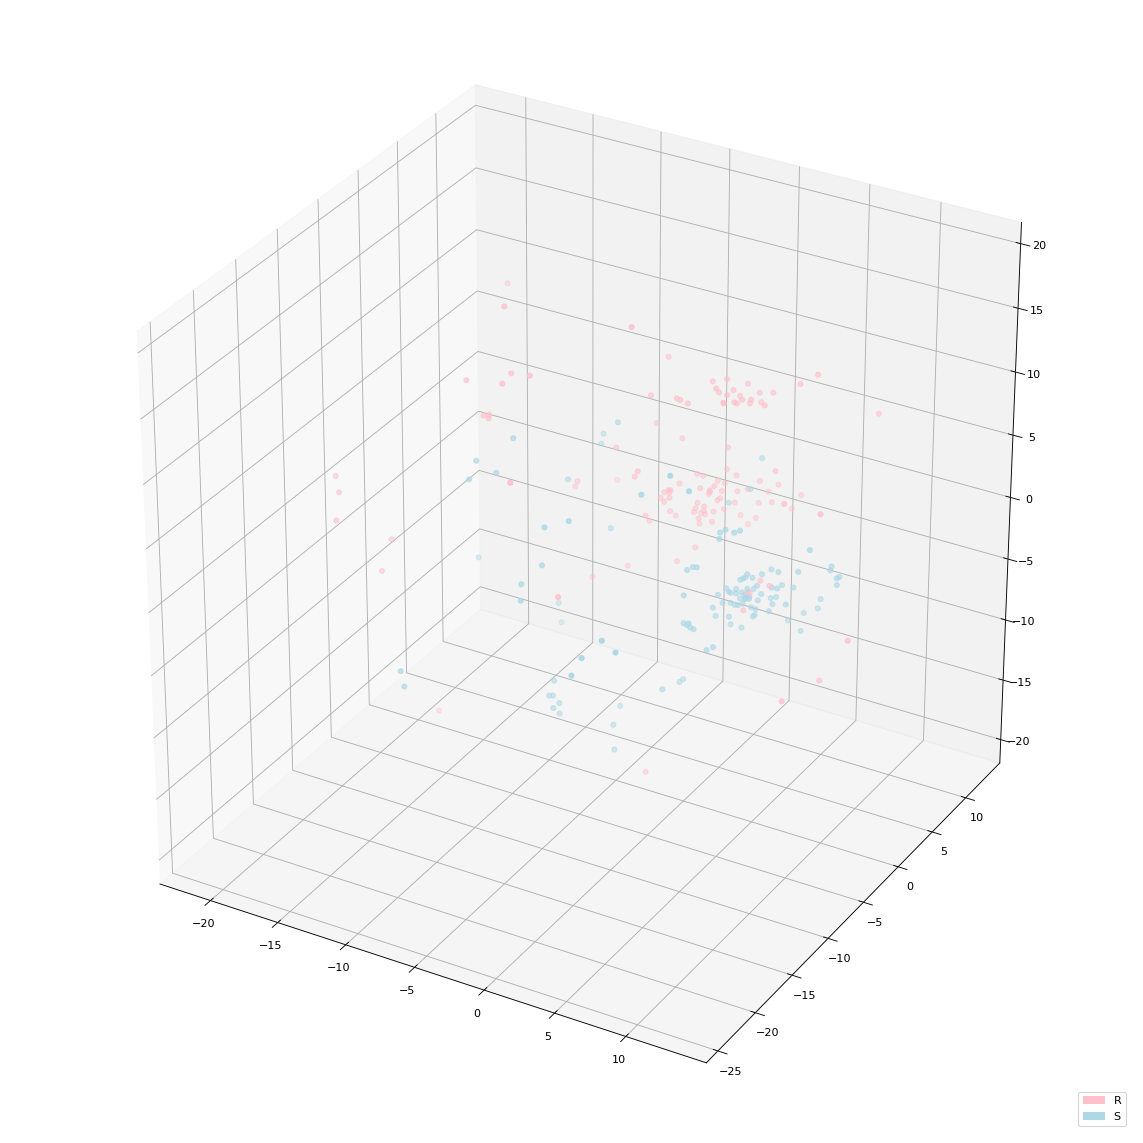

In [149]:
y = amr[:,1]


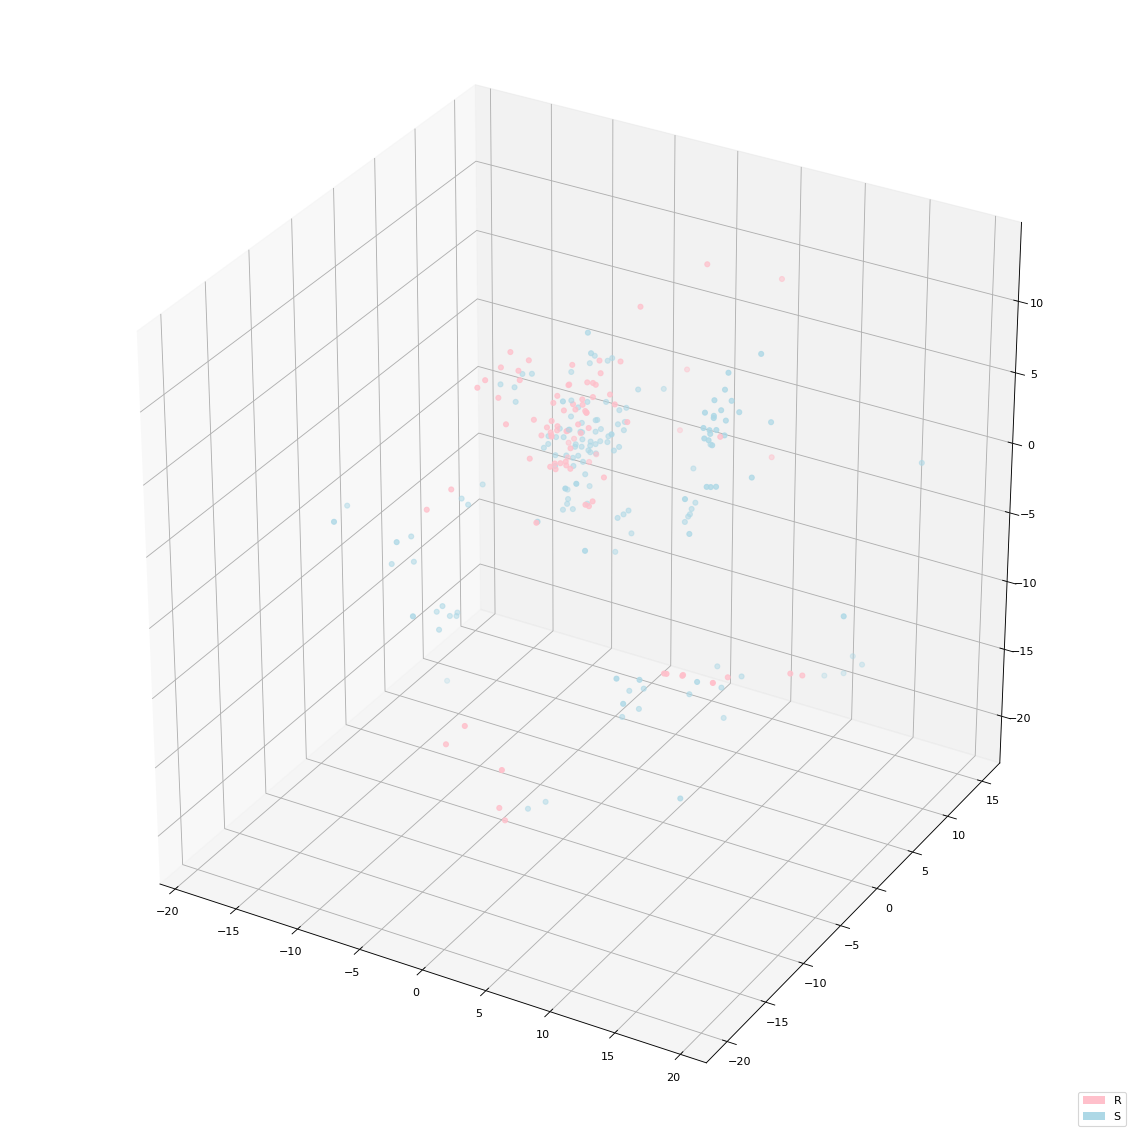

In [164]:
y = amr[:,0]
mds =  MDS(n_components=3, random_state=2, dissimilarity='precomputed', n_jobs=4)
D_mds3 = mds.fit_transform(D)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
N = D_mds3.shape[0]
fig = plt.figure(figsize=(14, 14), dpi= 80, facecolor='w', edgecolor='k')
ax = Axes3D(fig)
colours = np.array(['lightblue'] * N)
colours[y == 1] = 'pink'
ax.scatter(D_mds3[:, 0], D_mds3[:, 1], D_mds3[:, 2], c=colours)

# Legend
classes = ['R','S']
class_colours = ['pink','lightblue']
dots = []
for i in range(0,len(class_colours)):
    dots.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(dots,classes,loc=4)

plt.show()

In [125]:
amr[sample_index == "SRR2407587"]

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]])

In [133]:
y = amr[:,d_i]
y[sample_index == "SRR2407587"]

array([0])

In [130]:
sample_index[0:9]

SRA_Accession
75     SRR2407533
237    SRR2407540
43     SRR2407549
59     SRR2407550
214    SRR2407552
153    SRR2407553
146    SRR2407565
37     SRR2407567
53     SRR2407587
Name: SRA_Accession, dtype: object

In [131]:
genome_list[0:9]

Index(['SRR2407533', 'SRR2407540', 'SRR2407549', 'SRR2407550', 'SRR2407552',
       'SRR2407553', 'SRR2407565', 'SRR2407567', 'SRR2407587'],
      dtype='object')

In [296]:
valid = ~np.apply_along_axis(lambda c: sum(c == 0) < 30 or sum(c == 1) < 30, 0, amr)
amr = amr[:,valid]
np.array(amr_list)[valid]

array(['AMC', 'AMP', 'FOX', 'CRO', 'TIO', 'STR', 'SOX', 'TCY'],
      dtype='<U3')

In [312]:
np.corrcoef(amr, rowvar=False)[:,7]

array([-0.0977387 ,  0.29174107, -0.09259892, -0.10698993, -0.09259892,
        0.70695393,  0.4083195 ,  1.        ])

In [307]:
results[:,6]

array([ 0.,  0.,  0.,  0.])